In [49]:
import pandas as pd
import tushare as ts
from sqlalchemy import create_engine
import time
import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
import math
from sklearn.metrics import mean_squared_error

# 数据导入、清洗

In [2]:
# 导入token
with open('./parameters.json','r') as f:
    p=json.load(f)
    user = p['user']
    port = p['port']
    psw = p['password']
    host = p['host']
    token=p['TU_share_pro_taken']
    cnnstr = "mysql://" + user + ":" + psw + "@" + host + ":" + str(port) + "/stock?charset=utf8&use_unicode=1"
engine_ts = create_engine(cnnstr)
ts.set_token(token)

In [242]:
# 设置股票参数
ts_code='600000.SH'
startdate='20000101'
enddate='20201030'
startmonth='200001'
endmonth='202010'
startQ='2000Q1'
endQ='2020Q3'
pro = ts.pro_api()

In [243]:
# 获取股票历史
stock = ts.pro_bar(ts_code=ts_code, start_date=startdate, end_date=enddate,
                            asset='E', adj='qfq', freq='D')
stock=stock[['ts_code','trade_date','open','high','low','close','vol']]
stock.head(5)

,ts_code,trade_date,open,high,low,close,vol
0,600000.SH,20201030,9.38,9.45,9.25,9.26,560608.64
1,600000.SH,20201029,9.35,9.45,9.34,9.37,437073.48
2,600000.SH,20201028,9.48,9.52,9.38,9.40,458813.67
3,600000.SH,20201027,9.59,9.59,9.48,9.48,380627.80
4,600000.SH,20201026,9.72,9.75,9.59,9.60,527114.43


In [244]:
# 整理日期列，为后面吸收合并数据做准备
stock['datetime']=pd.to_datetime(stock['trade_date'],format='%Y%m%d')
stock['YYYYMM']=stock['trade_date'].str[0:6]
stock['YYYYQQ']=stock['datetime'].map(lambda x:str(x.year)+'Q'+str(x.quarter))
stock.head(5)


,ts_code,trade_date,open,high,low,close,vol,datetime,YYYYMM,YYYYQQ
0,600000.SH,20201030,9.38,9.45,9.25,9.26,560608.64,2020-10-30,202010,2020Q4
1,600000.SH,20201029,9.35,9.45,9.34,9.37,437073.48,2020-10-29,202010,2020Q4
2,600000.SH,20201028,9.48,9.52,9.38,9.40,458813.67,2020-10-28,202010,2020Q4
3,600000.SH,20201027,9.59,9.59,9.48,9.48,380627.80,2020-10-27,202010,2020Q4
4,600000.SH,20201026,9.72,9.75,9.59,9.60,527114.43,2020-10-26,202010,2020Q4


In [245]:
# 获取指数
if stockcode[-2:] == 'SZ':
    idxcode='399001.SZ'
else:
    idxcode='000001.SH'
idx = pro.index_daily(ts_code=idxcode,start_date=startdate,end_date=enddate,fields='trade_date,close,vol')
# idx.head(5)

In [246]:
# 合并指数,初始化combination
combination=pd.merge(stock,idx,how='left',on='trade_date',left_index=False,right_index=False,copy=True)
# combination.head(5)

In [247]:
# 获取M2
money = pro.cn_m(start_m=startmonth, end_m=endmonth, fields='month,m2')
money.rename(columns={'month':'YYYYMM'},inplace=True)
# money.head(5)

In [248]:
# 合并M2
combination=pd.merge(combination,money,how='left',on='YYYYMM',left_index=False,right_index=False,copy=True)
# combination.head(5)

In [249]:
# 获取财务指标
sql="select kpi,period,value from stock_analysis where code = '%s' and kpi in ('基本每股收益(元)','每股净资产(元)')" % stockcode[0:6]
finance = pd.read_sql_query(sql, engine_ts)
finance=finance.pivot('period','kpi','value')
finance.reset_index(inplace=True)
finance['period']= pd.to_datetime(finance['period'])
finance['YYYYQQ']=finance.period.map(lambda x: str(x.year)+'Q'+str(x.quarter))
finance.drop('period',axis=1,inplace=True)
# finance.head(5)

In [250]:
# 合并财务指标
combination=pd.merge(combination,finance,how='left',on='YYYYQQ',left_index=False,right_index=False,copy=True)
# combination.head(5)

In [251]:
# 日期从早到晚排序
combination.sort_values(by='trade_date',inplace=True)
combination.head(5)

,ts_code,trade_date,open,high,low,close_x,vol_x,datetime,YYYYMM,YYYYQQ,close_y,vol_y,m2,基本每股收益(元),每股净资产(元)
4926,600000.SH,20000104,NaN,NaN,NaN,NaN,44961.0,2000-01-04,200001,2000Q1,3497.060,7344508.0,118907.8,NaN,NaN
4925,600000.SH,20000105,NaN,NaN,NaN,NaN,52528.0,2000-01-05,200001,2000Q1,3486.285,9373897.0,118907.8,NaN,NaN
4924,600000.SH,20000106,NaN,NaN,NaN,NaN,62297.0,2000-01-06,200001,2000Q1,3655.199,11240481.0,118907.8,NaN,NaN
4923,600000.SH,20000107,NaN,NaN,NaN,NaN,213553.0,2000-01-07,200001,2000Q1,3828.040,29900111.0,118907.8,NaN,NaN
4922,600000.SH,20000110,NaN,NaN,NaN,NaN,165397.0,2000-01-10,200001,2000Q1,3921.484,26987105.0,118907.8,NaN,NaN


In [252]:
# 纵向填充，用晚的数据补充早的，用以填充很早没有数据的部分
combination.fillna(method='bfill',axis=0,inplace=True) 

In [253]:
# 纵向填充，用早的数据补充晚的，用以填充最近还没公布数据的部分
combination.fillna(method='ffill',axis=0,inplace=True) 

In [254]:
combination.drop(['ts_code','trade_date','datetime','YYYYMM','YYYYQQ'],axis=1,inplace=True)

In [255]:
combination=combination.iloc[:,0:4]

In [256]:
# 计算收盘价未来n天的平均价格
n=5
moving_ndays_close=[]
for i in range(0,len(combination)-n):
    ndays=combination.iloc[i:i+n,3]
    moving_ndays_close.append(np.mean(ndays))
moving_ndays_close=moving_ndays_close+list(combination['close_x'][-n:])  # 直接用收盘价来不足最后5天的移动平均价格
combination['moving_ndays_close']=moving_ndays_close
combination.tail(10)


,open,high,low,close_x,moving_ndays_close
9,9.73,9.93,9.64,9.65,9.656
8,9.63,9.65,9.51,9.58,9.646
7,9.58,9.70,9.51,9.70,9.626
6,9.67,9.76,9.59,9.65,9.566
5,9.63,9.79,9.62,9.70,9.510
4,9.72,9.75,9.59,9.60,9.600
3,9.59,9.59,9.48,9.48,9.480
2,9.48,9.52,9.38,9.40,9.400
1,9.35,9.45,9.34,9.37,9.370
0,9.38,9.45,9.25,9.26,9.260


In [257]:
# 将数据转成0-1之间
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(combination)
data

array([[0.0945161 , 0.09137293, 0.09427993, 0.09345206, 0.09319102],
       [0.0945161 , 0.09137293, 0.09427993, 0.09345206, 0.09319102],
       [0.0945161 , 0.09137293, 0.09427993, 0.09345206, 0.09319102],
       ...,
       [0.73911827, 0.72937178, 0.74331652, 0.73429779, 0.74074475],
       [0.7280945 , 0.72352632, 0.7398681 , 0.73174632, 0.73816657],
       [0.73063845, 0.72352632, 0.73210914, 0.7223909 , 0.72871323]])

In [258]:
data.shape

(4927, 5)

# 创建训练、测试数据集、创建模型，训练数据

In [259]:
# 划分训练集、测试集
training_size = int(len(data)*0.80)
test_size = len(data)-training_size
traing_data = data[0:training_size,:]
test_data = data[training_size:len(data),:]
traing_data.shape

(3941, 5)

In [260]:
# 构建函数来预处理数据,移动数据框
def create_dataset(dataset, back_days):
    X,Y=[],[]
    for i in range(back_days,len(dataset)):
        a=dataset[(i-back_days):i,:] # 0-99 行  所有列
        b=dataset[i,-1]# 100行 最后一列
        X.append(a)      
        Y.append(b) 
    return np.array(X), np.array(Y)

In [261]:
look_back=100
x_train,y_train = create_dataset(traing_data,back_days=look_back)
x_test,y_test = create_dataset(test_data,back_days=look_back)
x_train.shape,y_train.shape

((3841, 100, 5), (3841,))

In [262]:
#搭建模型
model = Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(16, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
# model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
model.add(Dense(1))
# model = load_model('my_LSTM_stock_model1000.h5')
#     adam = keras.optimizers.Adam(decay=0.2)

In [263]:
model.compile(loss='mse',optimizer='adam')

In [264]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 100, 32)           4864      
_________________________________________________________________
lstm_23 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________


In [265]:
# 训练数据
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
121/121 [==============================] - 6s 52ms/step - loss: 0.0235 - val_loss: 0.0014
Epoch 2/100
121/121 [==============================] - 6s 46ms/step - loss: 7.3216e-04 - val_loss: 0.0012
Epoch 3/100
121/121 [==============================] - 6s 47ms/step - loss: 6.5464e-04 - val_loss: 0.0010
Epoch 4/100
121/121 [==============================] - 5s 45ms/step - loss: 5.9737e-04 - val_loss: 9.8522e-04
Epoch 5/100
121/121 [==============================] - 6s 47ms/step - loss: 5.3909e-04 - val_loss: 0.0013
Epoch 6/100
121/121 [==============================] - 6s 46ms/step - loss: 5.5844e-04 - val_loss: 0.0012
Epoch 7/100
121/121 [==============================] - 6s 48ms/step - loss: 5.2514e-04 - val_loss: 8.2960e-04
Epoch 8/100
121/121 [==============================] - 6s 48ms/step - loss: 4.8221e-04 - val_loss: 0.0023
Epoch 9/100
121/121 [==============================] - 6s 48ms/step - loss: 4.7650e-04 - val_loss: 6.8093e-04
Epoch 10/100
121/121 [================

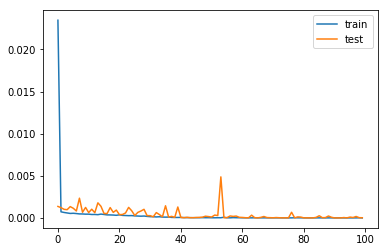

In [266]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [87]:
model.save('trained_model_stock_lstm_multiple_elements_%s' % ts_code)

INFO:tensorflow:Assets written to: trained_model_stock_lstm_multiple_elements_000001\assets


# 预测数据

In [267]:
# 预测数据
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
train_predict.shape,test_predict.shape

((3841, 1), (886, 1))

In [268]:
# 将结果组合成(2568,6) 方便后面还原数据
zero_train=np.zeros((train_predict.shape[0],data.shape[1]-1)) # 构建矩阵 1792 x 81
zero_test=np.zeros((test_predict.shape[0],data.shape[1]-1))
# 合并列，注意预测值放在第81列，因为当初归一化的时候y值就在81列
train_predict=np.column_stack((zero_train,train_predict)) 
test_predict=np.column_stack((zero_test,test_predict))
train_predict.shape,test_predict.shape

((3841, 5), (886, 5))

In [269]:
# 数据还原
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
train_predict

array([[ 0.7638    ,  0.7857    ,  0.7579    ,  0.7662    ,  1.77287848],
       [ 0.7638    ,  0.7857    ,  0.7579    ,  0.7662    ,  1.76633295],
       [ 0.7638    ,  0.7857    ,  0.7579    ,  0.7662    ,  1.75569808],
       ...,
       [ 0.7638    ,  0.7857    ,  0.7579    ,  0.7662    , 11.3446472 ],
       [ 0.7638    ,  0.7857    ,  0.7579    ,  0.7662    , 11.28382913],
       [ 0.7638    ,  0.7857    ,  0.7579    ,  0.7662    , 11.26989609]])

In [270]:
print(train_predict[:,-1])

[ 1.77287848  1.76633295  1.75569808 ... 11.3446472  11.28382913
 11.26989609]


In [271]:
# 计算结果准确度平方差
train_rmse= math.sqrt(mean_squared_error(y_train,train_predict[:,-1]))
test_rmse=math.sqrt(mean_squared_error(y_test,test_predict[:,-1]))
train_rmse,test_rmse

(4.705525652661569, 9.7643182201928)

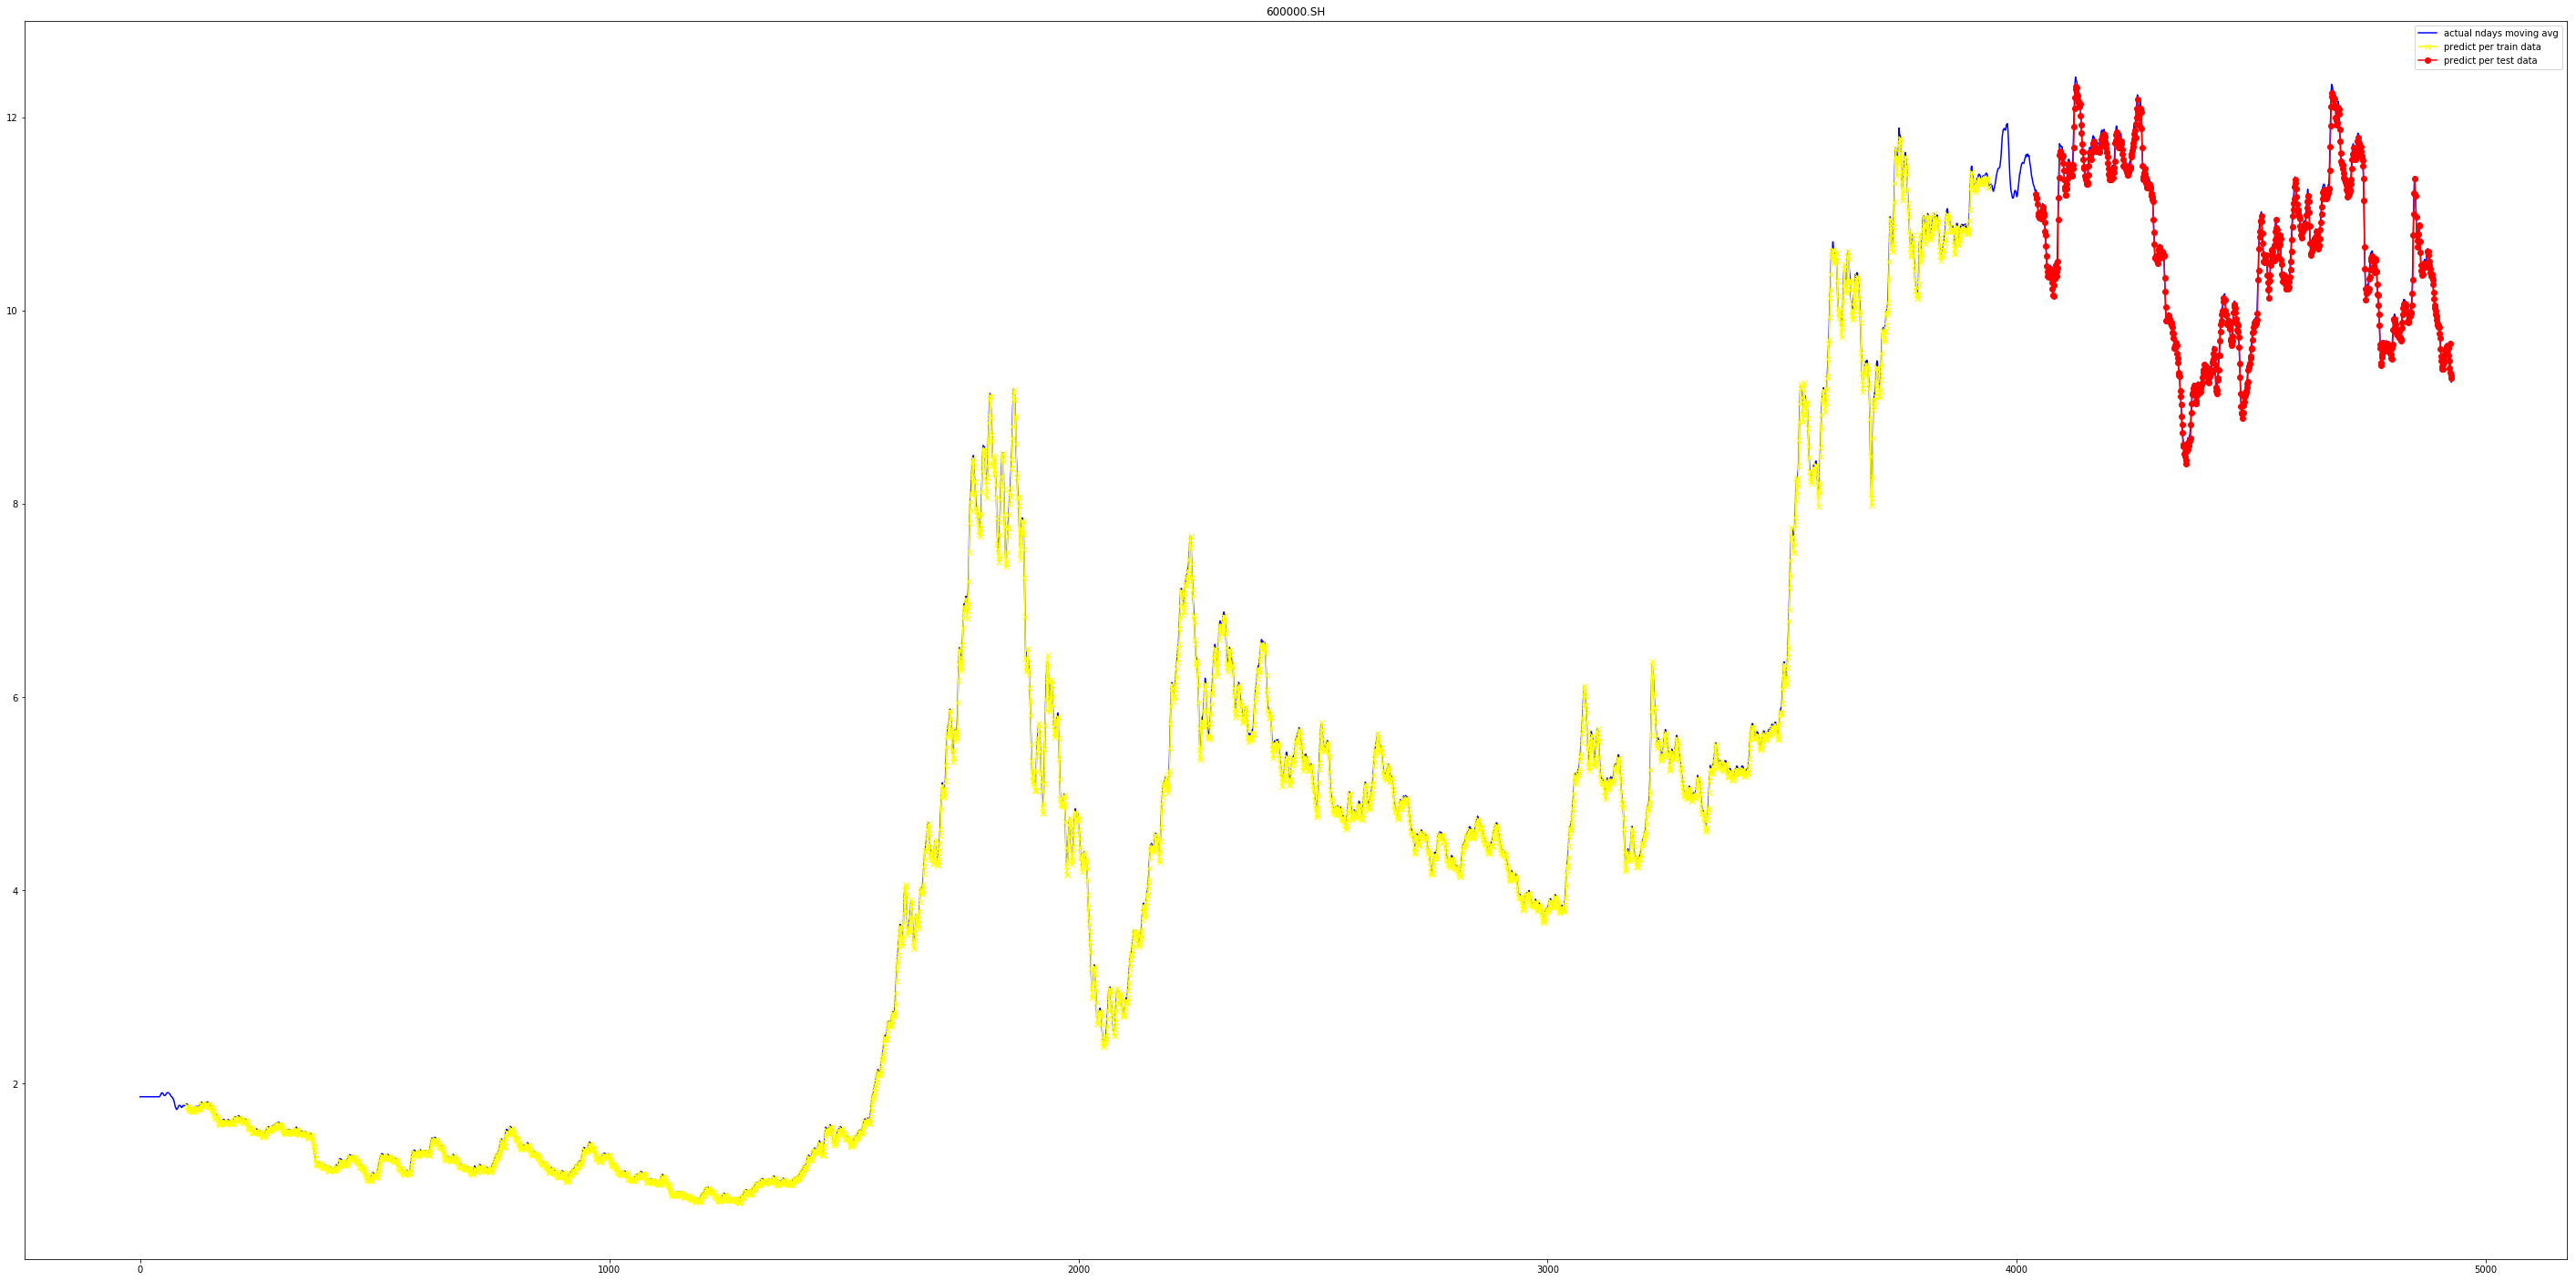

In [272]:
# 绘制计算结果图
trainPredictPlot=np.empty_like(combination['moving_ndays_close'])
trainPredictPlot[:]=np.nan
# 预测值赋给一个列表，位置整体往后移动100, 100:2667  2568个样本
trainPredictPlot[look_back:len(train_predict)+look_back]=train_predict[:,-1]

test_start_point=len(train_predict)+look_back*2 # 200+2568=2768 
testPredictPlot=np.empty_like(combination['moving_ndays_close'])
testPredictPlot[:]=np.nan
# 测试值赋给一个列表，位置整体往后移动100*2
testPredictPlot[test_start_point:]=test_predict[:,-1]
plt.figure(figsize=(50,25))
# plt.plot(list(df['close']),c='blue',label="close data")
# plt.plot(list(df['close']),c='black',label="price")
plt.plot(list(combination['moving_ndays_close']),c='blue',label="actual ndays moving avg")
plt.plot(trainPredictPlot,c='yellow',marker="x",label="predict per train data")
plt.plot(testPredictPlot,c='red',marker="o",label="predict per test data")
plt.title(ts_code)
plt.legend()
plt.show()

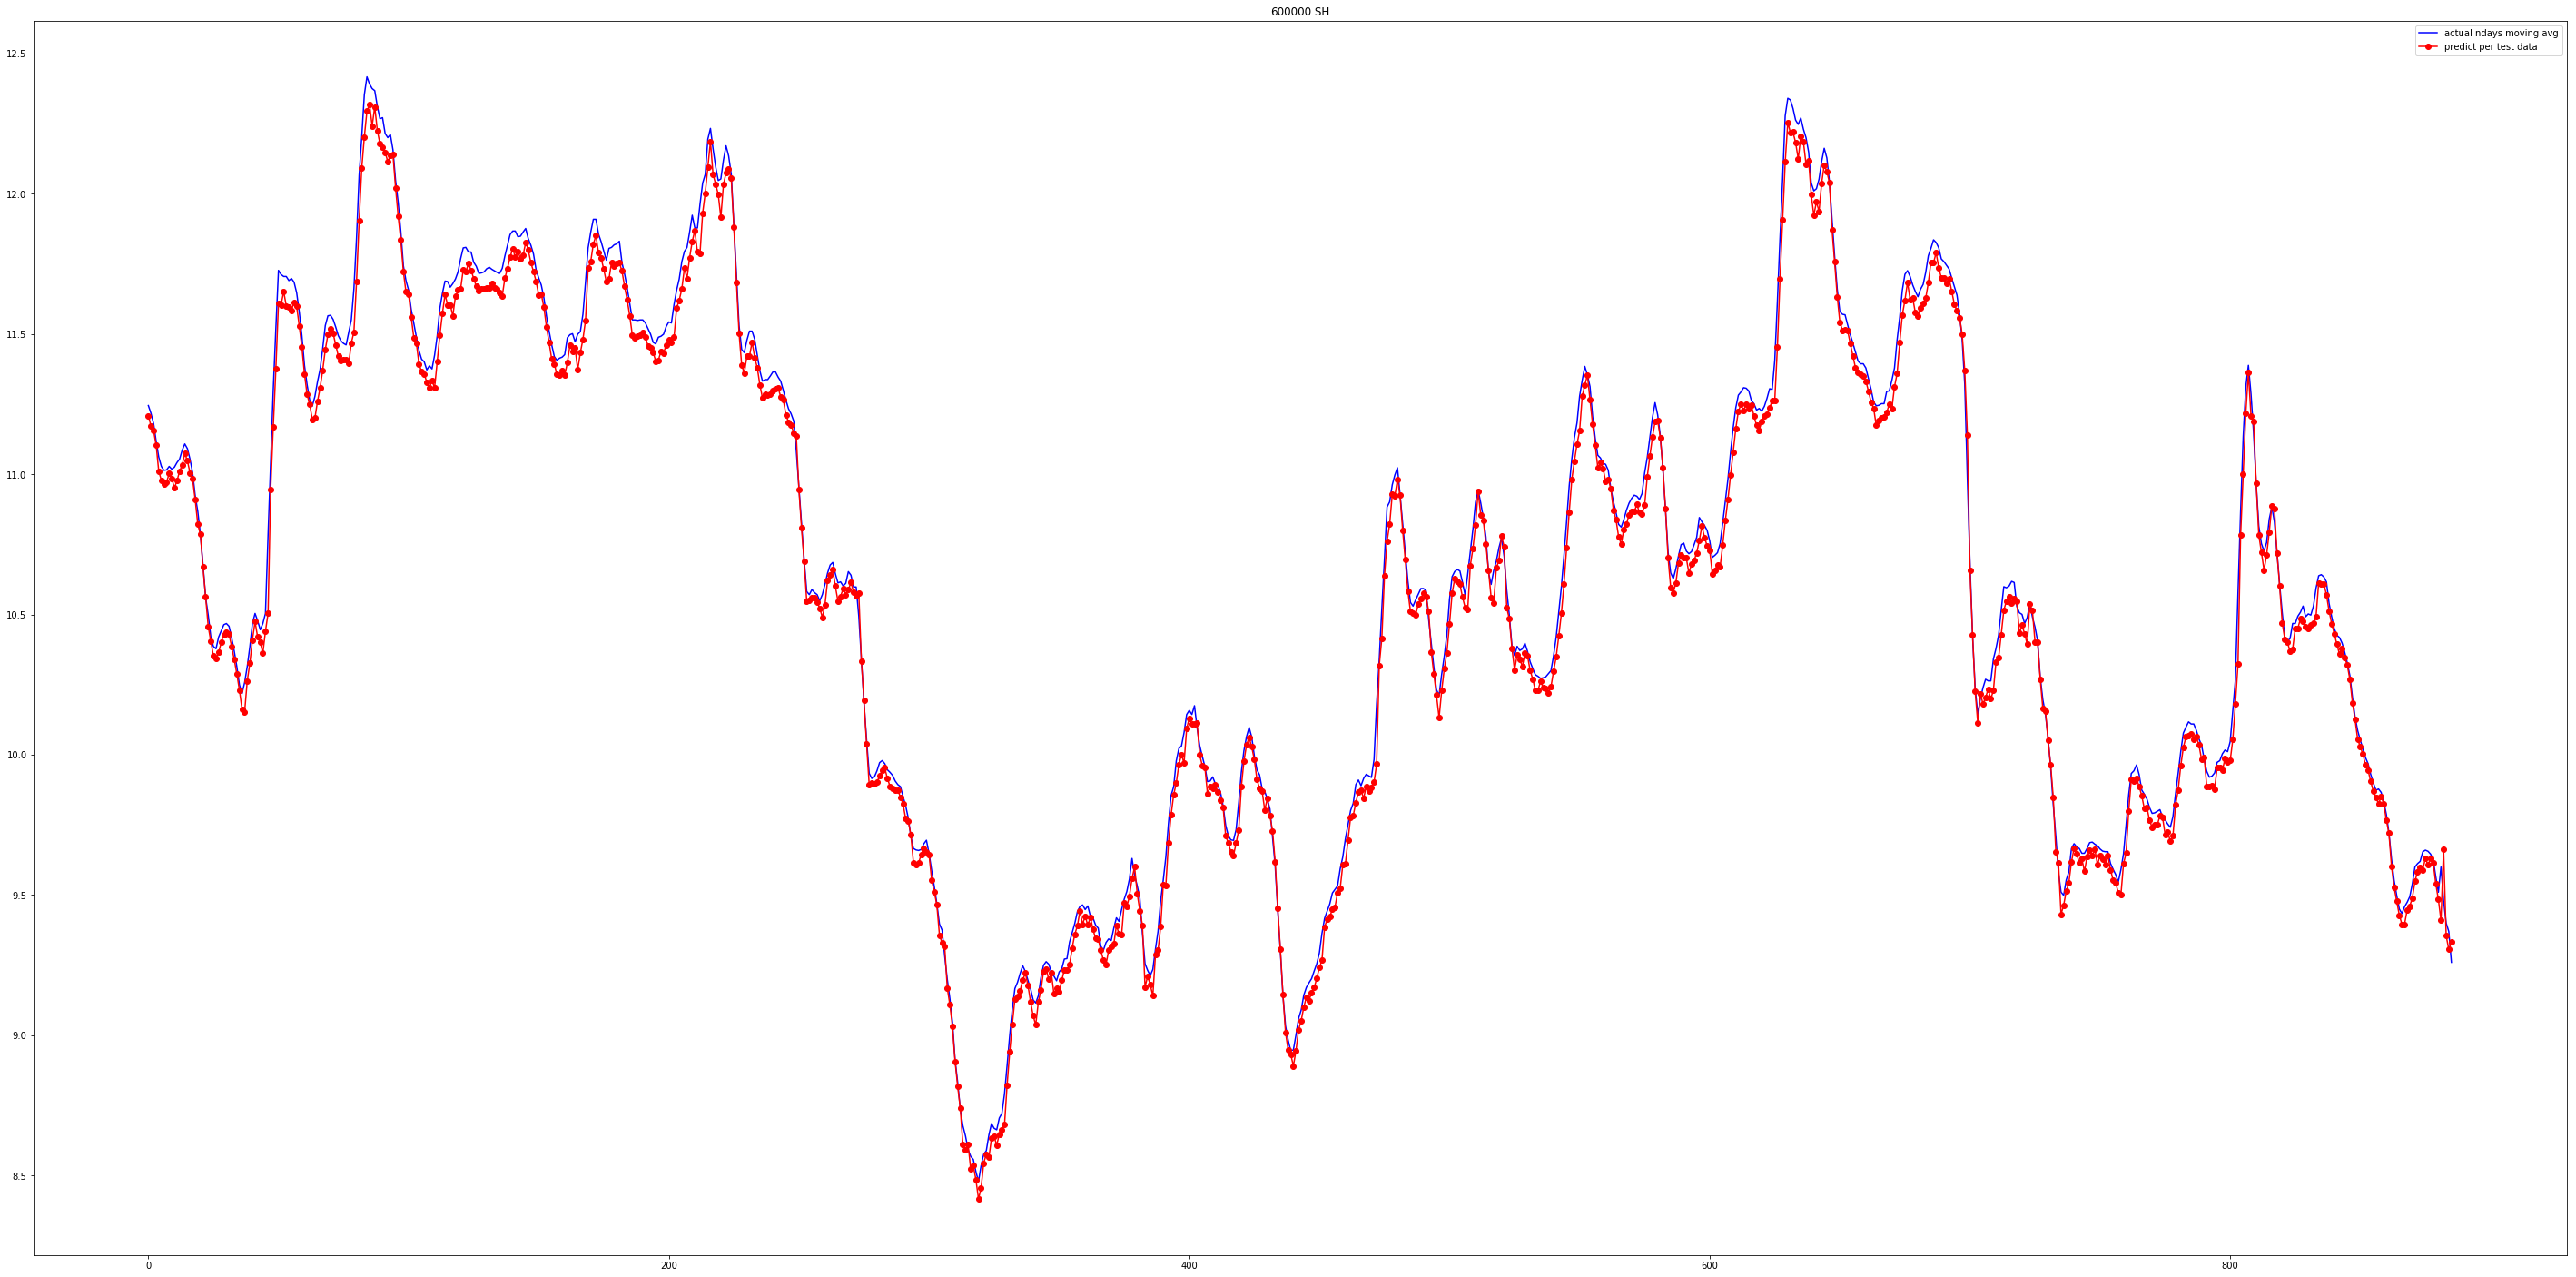

In [273]:
# 绘制测试集结果
plt.figure(figsize=(50,25))
# plt.plot(list(df['close']),c='blue',label="close data")
# plt.plot(list(df['close']),c='black',label="price")
plt.plot(list(combination['moving_ndays_close'][-test_predict.shape[0]:]),c='blue',label="actual ndays moving avg")
# plt.plot(trainPredictPlot,c='yellow',marker="x",label="predict per train data")
plt.plot(test_predict[:,-1],c='red',marker="o",label="predict per test data")
plt.title(ts_code)
plt.legend()
plt.show()

# 结果评价 

In [239]:
def model_score(model,x_train,y_train,x_test,y_test):
    trainScore = model.evaluate(x_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(x_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    
model_score(model, x_train, y_train, x_test, y_test)

TypeError: 'float' object is not subscriptable

In [159]:
def percentage_difference(model, x_test, y_test):
    percentage_diff=[]
    p = model.predict(x_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u
        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p
p = percentage_difference(model, x_test, y_test)
# p